# Homework 4 - Q3

## Question - 3

In [1]:
import pandas as pd
df = pd.read_csv('jena_climate_2009_2016.csv', parse_dates=True, index_col='Date Time',infer_datetime_format=True)
xt = df['T (degC)']
xt = xt.reset_index(drop=True)

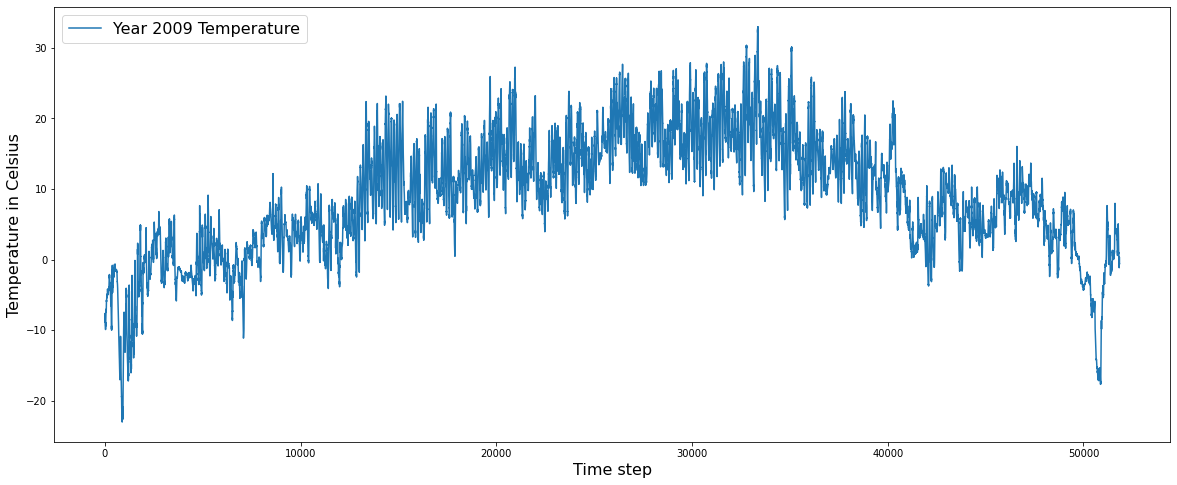

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
plt.figure(figsize=(20, 8))

plt.plot(xt[:4320*12])
plt.ylabel('Temperature in Celsius',fontsize=16)
plt.xlabel('Time step',fontsize=16)
plt.legend(['Year 2009 Temperature'], loc='upper left',fontsize=16)
plt.show()

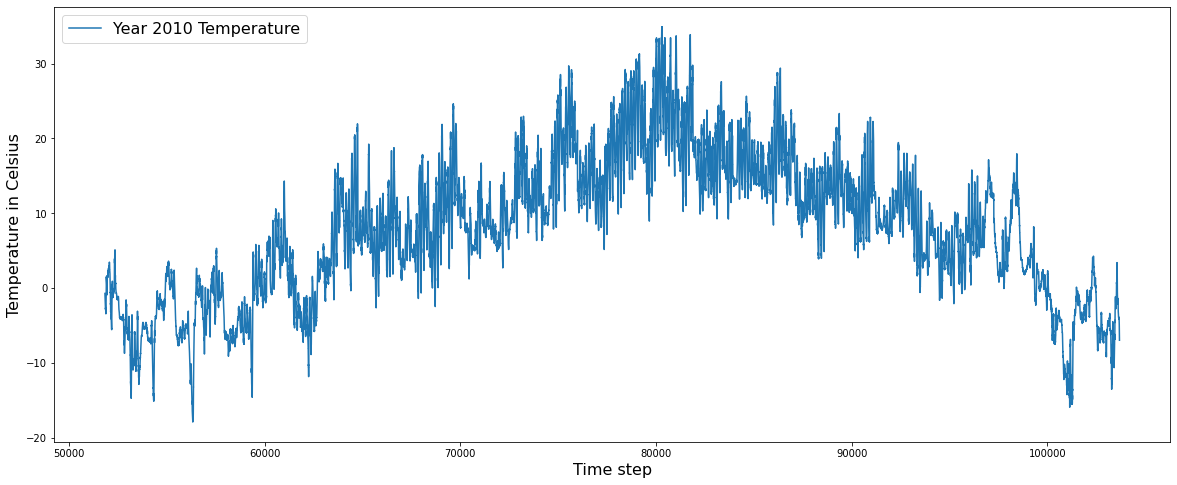

In [3]:
plt.figure(figsize=(20, 8))

plt.plot(xt[4320*12:4320*24])
plt.ylabel('Temperature in Celsius',fontsize=16)
plt.xlabel('Time step',fontsize=16)
plt.legend(['Year 2010 Temperature'], loc='upper left',fontsize=16)
plt.show()

In [4]:
# split a univariate sequence into samples
import numpy as np
#Function definition used from "https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/"
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [5]:
n_timesteps=6
# split into samples
#Looks at 1 hour temperature data to predict the temperature
X, y = split_sequence(xt, n_timesteps)
X[10]

array([-8.76, -8.88, -8.85, -8.83, -8.66, -8.66])

In [6]:
X_train=X[:int(len(X)*.8)]
X_test=X[int(len(X)*.8):len(X)]

y_train=y[:int(len(y)*.8)]
y_test=y[int(len(y)*.8):len(y)]

In [7]:
X_test_1400=X_test[len(X_test)-1440:]
y_test_1400=y_test[len(y_test)-1440:]

In [8]:
from keras import models,layers,optimizers
from keras.layers import LSTM,SimpleRNN,Dropout

#Looks at 1 hour temperature data to predict the temperature
n_features=1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
X_test_1400 = X_test_1400.reshape((X_test_1400.shape[0], X_test_1400.shape[1], n_features))


model = models.Sequential()
model.add(LSTM(12,activation='relu',input_shape=(n_timesteps,n_features)))
model.add(layers.Dense(1,activation='linear'))
model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 12)                672       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 13        
Total params: 685
Trainable params: 685
Non-trainable params: 0
_________________________________________________________________


In [9]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
batch=256
callbacks = [EarlyStopping(monitor='val_loss', patience=3),
             ModelCheckpoint(filepath='HW4_Q3.h5', monitor='val_loss')]

#epochs=len(X_train)/(batch*2)
epochs=50
model.compile(loss='mse', optimizer=optimizers.Adam(learning_rate=0.0005,beta_1=0.85,beta_2=0.95))
history = model.fit(X_train,y_train, batch_size=batch,epochs=epochs,
          shuffle=False,validation_data=(X_test, y_test),callbacks=callbacks)

Train on 336436 samples, validate on 84109 samples
Epoch 1/50
336436/336436 [==============================] - 27s 81us/step - loss: 25.1440 - val_loss: 0.1631
Epoch 2/50
336436/336436 [==============================] - 27s 82us/step - loss: 0.1870 - val_loss: 0.0904
Epoch 3/50
336436/336436 [==============================] - 27s 80us/step - loss: 0.0693 - val_loss: 0.0580
Epoch 4/50
336436/336436 [==============================] - 27s 81us/step - loss: 0.0631 - val_loss: 0.0652
Epoch 5/50
336436/336436 [==============================] - 27s 81us/step - loss: 0.0565 - val_loss: 0.0572
Epoch 6/50
336436/336436 [==============================] - 27s 81us/step - loss: 0.0550 - val_loss: 0.0575
Epoch 7/50
336436/336436 [==============================] - 27s 81us/step - loss: 0.0536 - val_loss: 0.0528
Epoch 8/50
336436/336436 [==============================] - 27s 80us/step - loss: 0.0513 - val_loss: 0.0522
Epoch 9/50
336436/336436 [==============================] - 27s 81us/step - loss: 0.

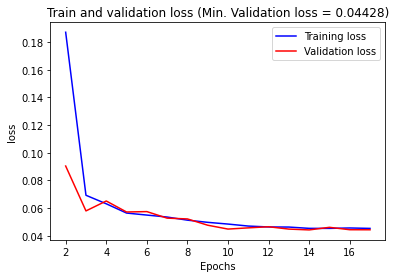

In [14]:
import matplotlib

plt.clf()   # clear figure
ax=plt.gca()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(2, len(loss) + 1)

plt.plot(epochs, loss[1:], 'b', label='Training loss')
plt.plot(epochs, val_loss[1:], 'r', label='Validation loss')
plt.title('Train and validation loss (Min. Validation loss = '+str(round(min(val_loss),5))+')')
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2))
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

In [11]:
X_hat_1400 = model.predict(X_test_1400, verbose=0)
print(X_hat_1400)

[[-2.6577442]
 [-2.6060338]
 [-2.459128 ]
 ...
 [-3.081873 ]
 [-3.0692992]
 [-4.36388  ]]


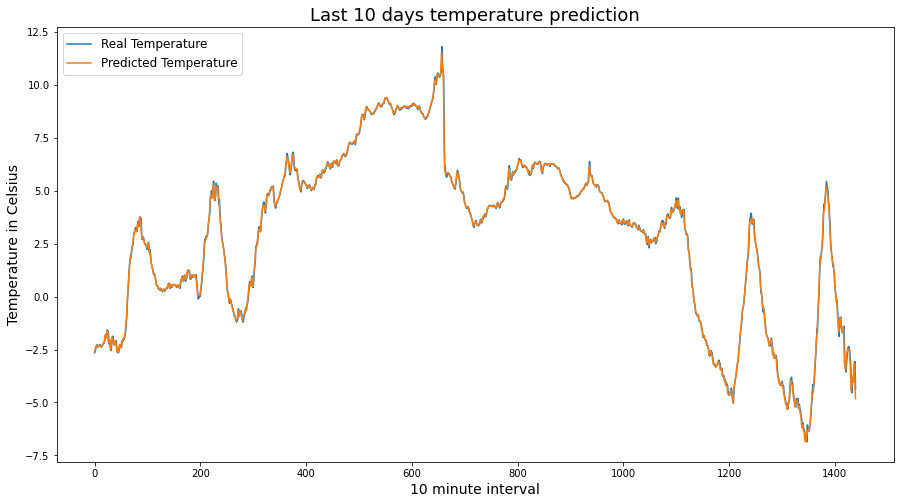

In [12]:
plt.figure(figsize=(15, 8))

plt.plot(X_hat_1400)
plt.plot(y_test_1400)
plt.ylabel('Temperature in Celsius',fontsize=14)
plt.xlabel('10 minute interval',fontsize=14)
plt.legend(['Real Temperature','Predicted Temperature'], loc='upper left',fontsize=12)
plt.title('Last 10 days temperature prediction',fontsize=18)
plt.show()

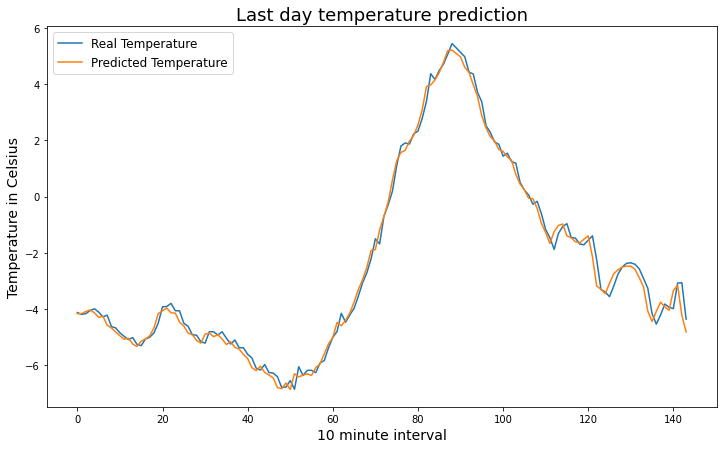

In [13]:
plt.figure(figsize=(12,7))

plt.plot(X_hat_1400[len(X_hat_1400)-144:])
plt.plot(y_test_1400[len(X_hat_1400)-144:])
plt.ylabel('Temperature in Celsius',fontsize=14)
plt.xlabel('10 minute interval',fontsize=14)
plt.legend(['Real Temperature','Predicted Temperature'], loc='upper left',fontsize=12)
plt.title('Last day temperature prediction',fontsize=18)
plt.show()